In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

matplotlib.style.use("ggplot")
from ipywidgets import interact
import numpy as np
import matplotlib as mpl
import arrow
from matplotlib import animation, rc
from IPython.display import HTML
from datetime import timedelta
import altair as alt


%matplotlib inline

In [10]:
#############################################################################
# Prepare data and import into a dataframe
#############################################################################

# Export Data from healthkit using [qs-access](https://itunes.apple.com/us/app/qs-access/id920297614?mt=8) app
exported_and_trandformed_csv_file = "data/weight.csv"
df = pd.read_csv(exported_and_trandformed_csv_file)

idx_weight_kg = "Weight (kg)"
idx_weight = "Weight (lb)"
# make dateColumn a datetime.
idx_date = "Start"
df[idx_date] = pd.to_datetime(df[idx_date])
df = df.set_index(df[idx_date])
# Create Time Period Groups
idx_month_year = "month_year"
df[idx_month_year] = df.index.to_series().apply(lambda t: arrow.get(t).format("MMM-YY"))

idx_week_year = "week_year"
df[idx_week_year] = df.index.to_series().apply(lambda t: f"{t.week}-{t.year-2000}")

#########################
# Clean data
###########################

# Remove 0 weight values.
df = df.replace(0, np.nan)
# Throw away junk data at the start of time
df = df["2010/1/1":]  # type: ignore


# (not sure why mypy can't handle this)
# KG to lbs
# df[idx_weight] = df[idx_weight_kg] * 2.2
# df[idx_weight] = df[idx_weight_kg]

# Throw away any weights less then 100
df = df[df[idx_weight] > 100]

dfW = df[idx_weight]


# Remove any rows with 0 values


# Helpful time aliases
df_alltime = df

In [11]:
def box_plot_weight_over_time(df, x, title=""):
    # In theory can use plot.ly (not free)  or Bokeh (not mpl compatible) but issues. So setting dimensions old school.
    # Manually setting the weight and width.
    height_in_inches = 8
    mpl.rc("figure", figsize=(2 * height_in_inches, height_in_inches))

    ax = sns.boxplot(x=x, y=idx_weight, data=df)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set_title(title)
    ax.set_xlabel("date")
    ax.set_ylabel("lbs")
    plt.show()


def box_plot_weight_over_time_sigh_vegas_broken(df, x, title, domain=(150, 250)):
    height_in_inches = 4 * 60  # todo figure out how to get this by calculation
    display(df)
    c = (
        alt.Chart(df)
        .mark_boxplot()
        .encode(y=alt.Y(idx_weight, scale=alt.Scale(domain=domain, clamp=True)), x=x)
        .properties(width=4 * height_in_inches, height=height_in_inches, title=title)
        .interactive()
    )
    display(c)

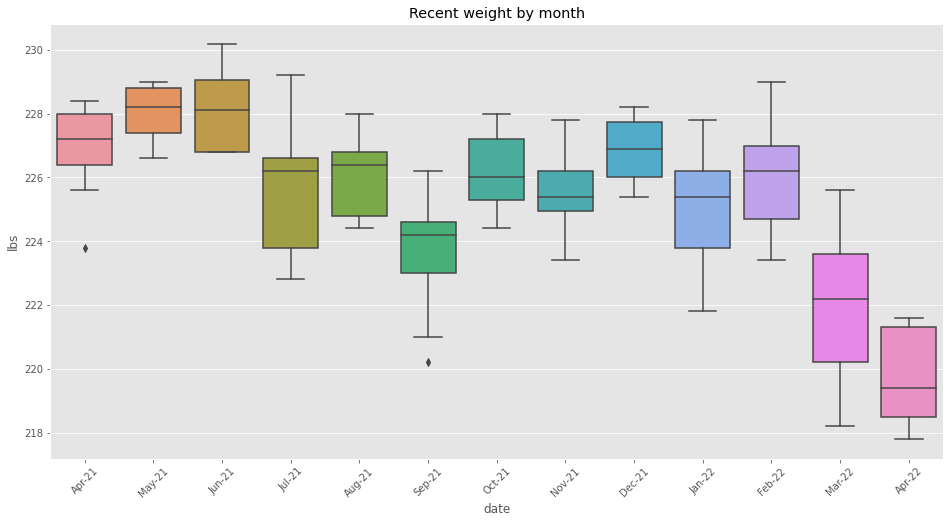

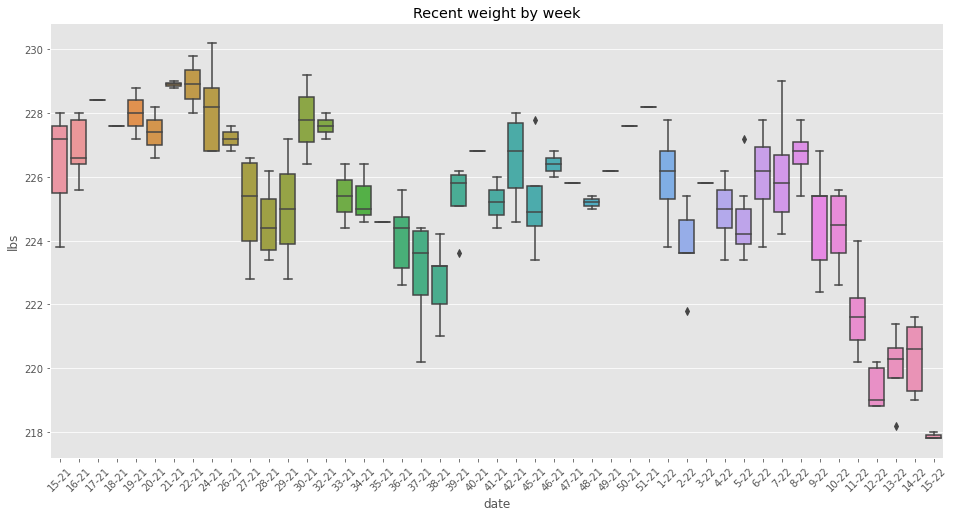

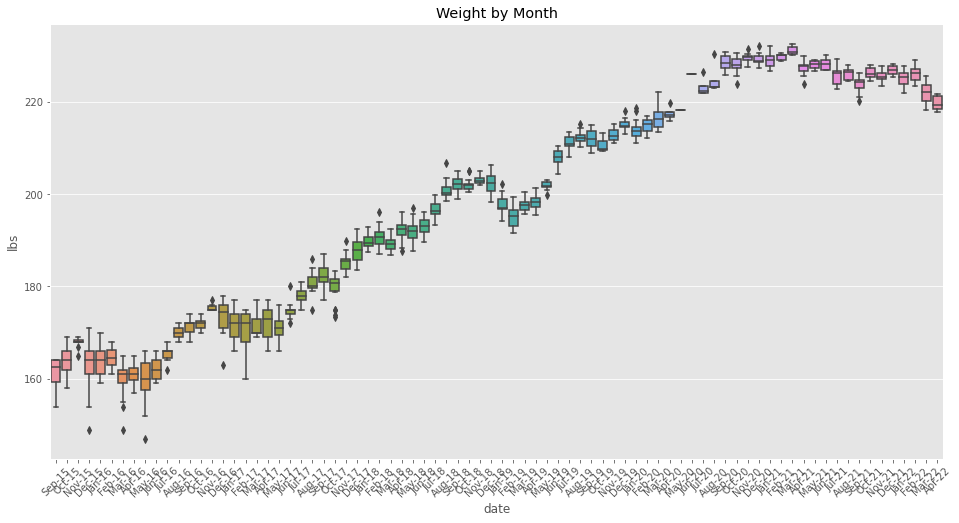

In [12]:
earliest = arrow.utcnow().shift(months=-12).date()
box_plot_weight_over_time(df[earliest:], idx_month_year, title="Recent weight by month")
box_plot_weight_over_time(df[earliest:], idx_week_year, title="Recent weight by week")
box_plot_weight_over_time(df_alltime, idx_month_year, "Weight by Month")

# Time Series Analysis using resampling

In [13]:
print("Scroll to see year markers, select in index to zoom in")
metric = idx_weight


def graph_weight_as_line(df, freq, domain):
    pd_freq_value = freq[0]  # hack, pandas Freq are D,W,M
    df_group_time = df.copy()[metric].resample(pd_freq_value)
    t1 = df_group_time.count().reset_index()
    # Create the root df for output
    df_to_graph = t1.drop(columns=metric)
    for q in [0.25, 0.5, 0.75, 0.9]:
        df_to_graph[f"p{q*100}"] = df_group_time.quantile(q).reset_index()[metric]

    # No start adding back the rows
    df_melted = df_to_graph.melt(
        id_vars=["Start"],
    )
    height_in_inches = 60  # todo figure out how to get this by calculation
    selection = alt.selection_multi(fields=["variable"], bind="legend")
    c = (
        alt.Chart(df_melted)
        .mark_line(point=True)
        .encode(
            y=alt.Y("value", title="", scale=alt.Scale(domain=domain)),
            x="Start:T",
            color="variable",
            tooltip=["idate:T", "value:Q"],
            opacity=alt.condition(selection, alt.value(1), alt.value(0.2)),
        )
        .properties(
            width=16 * height_in_inches,
            height=6 * height_in_inches,
            title=f"{metric} By {freq}",
        )
        .interactive()
    ).add_selection(selection)

    display(c)


earliest = arrow.utcnow().shift(months=-12).date()
graph_weight_as_line(df[earliest:], "Week", (200, 240))
for freq in "Month Week".split():
    graph_weight_as_line(df, freq, (150, 240))

Scroll to see year markers, select in index to zoom in


alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

In [14]:
dfM = dfW.resample("W").median()

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/matplotlib/animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


RuntimeError: Requested MovieWriter (ffmpeg) not available

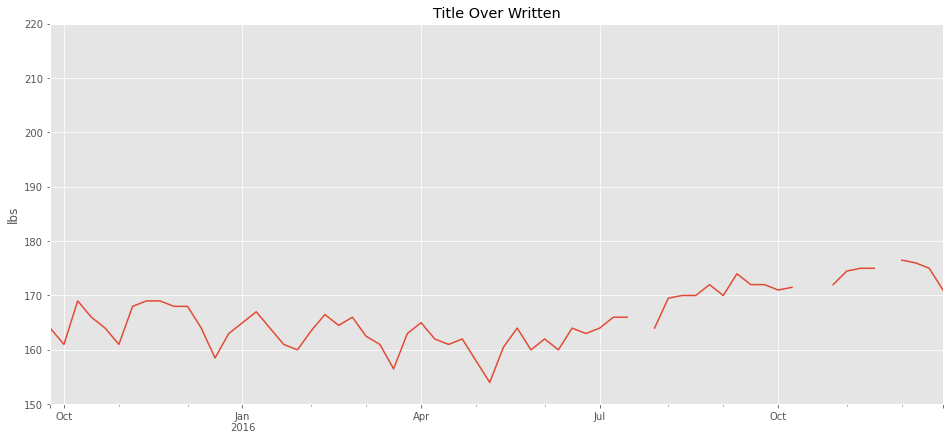

In [15]:
anim_year_base = 2016
anim_fig_size = (16, 7)
fig = plt.figure(figsize=anim_fig_size)
ax = fig.add_subplot(1, 1, 1)
dfM[:f"{anim_year_base}"].plot(
    title=f"Title Over Written", figsize=anim_fig_size, ylim=(150, 220), ax=ax
)
ax.set_ylabel("lbs")
ax.set_xlabel("")


def animate(i):
    year = f"{anim_year_base+i}"
    return dfM[:year].plot(title=f"Weight through {year}").lines


years_to_plot = 5
anim = animation.FuncAnimation(
    fig,
    animate,
    frames=years_to_plot,
    interval=timedelta(seconds=2).seconds * 1000,
    blit=False,
)
# HTML(anim.to_html5_video())
# TODO - how to get rid of the initial plot from animate.init() -- no clue.